In [1]:
import os
import json

import numpy as np
import pandas as pd
import keras
from keras.callbacks import Callback
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
os.listdir('../input')

['iwildcam-2019-fgvc6', 'reducing-image-sizes-to-32x32']

## 1. Loading the 32x32 dataset

In [3]:
# The data, split between train and test sets:
x_train = np.load('../input/reducing-image-sizes-to-32x32/X_train.npy')
x_test = np.load('../input/reducing-image-sizes-to-32x32/X_test.npy')
y_train = np.load('../input/reducing-image-sizes-to-32x32/y_train.npy')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (196299, 32, 32, 3)
196299 train samples
153730 test samples


In [4]:
# Convert the images to float and scale it to a range of 0 to 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

## 2. Create Callback for F1 score

In [5]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_pred = self.model.predict(X_val)

        y_pred_cat = keras.utils.to_categorical(
            y_pred.argmax(axis=1),
            num_classes=num_classes
        )

        _val_f1 = f1_score(y_val, y_pred_cat, average='macro')
        _val_recall = recall_score(y_val, y_pred_cat, average='macro')
        _val_precision = precision_score(y_val, y_pred_cat, average='macro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

        print((f"val_f1: {_val_f1:.4f}"
               f" — val_precision: {_val_precision:.4f}"
               f" — val_recall: {_val_recall:.4f}"))

        return

## 3. Creating and Training the Model

In [6]:
batch_size = 64
num_classes = 14
epochs = 30
val_split = 0.1
save_dir = os.path.join(os.getcwd(), 'models')
model_name = 'keras_cnn_model.h5'

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
f1_metrics = Metrics()

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

hist = model.fit(
    x_train, 
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[f1_metrics],
    validation_split=val_split,
    shuffle=True
)

Instructions for updating:
Use tf.cast instead.
Train on 176669 samples, validate on 19630 samples
Epoch 1/30
176669/176669 [==============================] - 22s 127us/step - loss: 0.7001 - acc: 0.7812 - val_loss: 0.4952 - val_acc: 0.8401
val_f1: 0.5076 — val_precision: 0.5960 — val_recall: 0.4880
Epoch 2/30
  1088/176669 [..............................] - ETA: 19s - loss: 0.5757 - acc: 0.8088

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


176669/176669 [==============================] - 19s 107us/step - loss: 0.5119 - acc: 0.8338 - val_loss: 0.4132 - val_acc: 0.8644
val_f1: 0.6642 — val_precision: 0.7157 — val_recall: 0.6483
Epoch 3/30
176669/176669 [==============================] - 19s 107us/step - loss: 0.4536 - acc: 0.8519 - val_loss: 0.3732 - val_acc: 0.8796
val_f1: 0.7083 — val_precision: 0.7431 — val_recall: 0.7002
Epoch 4/30
176669/176669 [==============================] - 19s 107us/step - loss: 0.4148 - acc: 0.8626 - val_loss: 0.3556 - val_acc: 0.8835
val_f1: 0.7184 — val_precision: 0.7593 — val_recall: 0.6998
Epoch 5/30
176669/176669 [==============================] - 19s 108us/step - loss: 0.3918 - acc: 0.8703 - val_loss: 0.3272 - val_acc: 0.8915
val_f1: 0.7432 — val_precision: 0.7795 — val_recall: 0.7286
Epoch 6/30
176669/176669 [==============================] - 19s 106us/step - loss: 0.3747 - acc: 0.8745 - val_loss: 0.3086 - val_acc: 0.8981
val_f1: 0.7401 — val_precision: 0.7884 — val_recall: 0.7169
Epoch 

Save model and weights

In [9]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /kaggle/working/models/keras_cnn_model.h5 


## 4. Evaluation

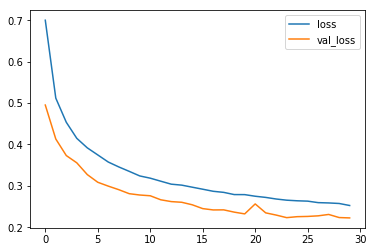

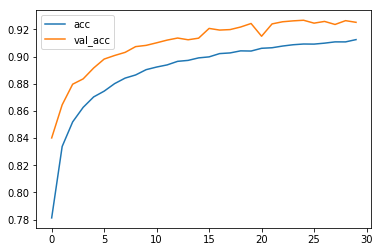

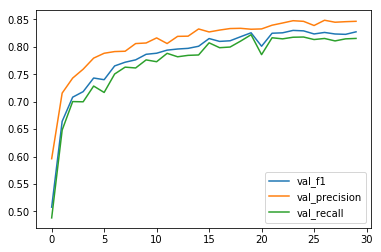

In [10]:
history_df = pd.DataFrame(hist.history)
history_df['val_f1'] = f1_metrics.val_f1s
history_df['val_precision'] = f1_metrics.val_precisions
history_df['val_recall'] = f1_metrics.val_recalls

history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()
history_df[['val_f1', 'val_precision', 'val_recall']].plot()

## 5. Submission

In [11]:
y_test = model.predict(x_test)

submission_df = pd.read_csv('../input/iwildcam-2019-fgvc6/sample_submission.csv')
submission_df['Predicted'] = y_test.argmax(axis=1)
print(submission_df.shape)
submission_df.head()

(153730, 2)


,Id,Predicted
0,b005e5b2-2c0b-11e9-bcad-06f10d5896c4,0
1,f2347cfe-2c11-11e9-bcad-06f10d5896c4,1
2,27cf8d26-2c0e-11e9-bcad-06f10d5896c4,0
3,f82f52c7-2c1d-11e9-bcad-06f10d5896c4,0
4,e133f50d-2c1c-11e9-bcad-06f10d5896c4,0


In [12]:
submission_df.to_csv('submission.csv',index=False)
history_df.to_csv('history.csv', index=False)

with open('history.json', 'w') as f:
    json.dump(hist.history, f)